# TME 1 - ADL: Variational Auto-Encoders

In [54]:
# support
# https://medium.com/geekculture/variational-autoencoder-vae-9b8ce5475f68
# https://medium.com/data-science/intuitively-understanding-variational-autoencoders-1bfe67eb5daf
# https://medium.com/@jimwang3589/variational-autoencoder-vae-7609893c80f4
# https://medium.com/@rekalantar/variational-auto-encoder-vae-pytorch-tutorial-dce2d2fe0f5f

# imports

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torchvision
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# loading data

transform = transforms.Compose([
  transforms.ToTensor()
])

train_dataset = torchvision.datasets.MNIST('.', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST('.', train=False, download=True, transform=transform)


train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128)

In [19]:
# model

class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()

        # x -> latent dim
        self.encoder = nn.Sequential(nn.Linear(input_dim, hidden_dim),
                                     nn.ReLU(),
                                     nn.Linear(hidden_dim, latent_dim),
                                     nn.ReLU()
                                    )

        # latent dim -> dim = 2 -> mean and var
        self.mean = nn.Linear(latent_dim, 2)
        self.var = nn.Linear(latent_dim, 2)

        # sample z using mean and var
        # z -> x
        self.decoder = nn.Sequential(nn.Linear(2, latent_dim),
                                     nn.ReLU(),
                                     nn.Linear(latent_dim, hidden_dim),
                                     nn.ReLU(),
                                     nn.Linear(hidden_dim, input_dim),
                                     nn.Sigmoid()
                                    )


    def encode(self, x):
        x = self.encoder(x)
        mean = self.mean(x)
        var = self.var(x)
        return mean, var
        
    def reparametrization(self, mean, var):
        e = torch.randn_like(var)
        z = mean + var*e
        return z
        
    def decode(self, z):
        x = self.decoder(z)
        return x
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        mean, var = self.encode(x)
        z = self.reparametrization(mean, var)
        x_hat = self.decode(z)
        return x_hat, mean, var

In [57]:
# training loop 

model = VAE(input_dim = 28*28, hidden_dim = 400, latent_dim = 20)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 50

for epoch in range(epochs):
    
    model.train()
    
    losses = 0
    
    for batch_idx, (data, _) in enumerate(train_loader):
        optimizer.zero_grad()
        x_hat, mean, var = model(data)

        # BCE term
        BCE = F.binary_cross_entropy(x_hat, data.view(-1, 28*28), reduction='sum')
        
        # KL Divergence term
        KLD = -0.5 * torch.sum(1 + var - mean.pow(2) - var.exp())
        
        loss = BCE + KLD
        
        loss.backward()
        losses += loss.item()
        optimizer.step()

    print(f'Epoch {epoch + 1}, Loss: {losses / len(train_loader.dataset)}')

Epoch 1, Loss: 188.93192290039062
Epoch 2, Loss: 158.97585244140626
Epoch 3, Loss: 154.38556725260418
Epoch 4, Loss: 151.11469923502605
Epoch 5, Loss: 148.7646920247396
Epoch 6, Loss: 146.98955771484376
Epoch 7, Loss: 145.67064845377604
Epoch 8, Loss: 144.66470102539063
Epoch 9, Loss: 143.74242967122396
Epoch 10, Loss: 142.9458520670573
Epoch 11, Loss: 142.16755973307292
Epoch 12, Loss: 141.64222526041667
Epoch 13, Loss: 141.07816572265625
Epoch 14, Loss: 140.52615600585938
Epoch 15, Loss: 140.3936031575521
Epoch 16, Loss: 139.81009809570313
Epoch 17, Loss: 139.31677898763022
Epoch 18, Loss: 138.86557975260416
Epoch 19, Loss: 138.53684033203126
Epoch 20, Loss: 138.24649142252605
Epoch 21, Loss: 138.01316761067707
Epoch 22, Loss: 137.74184220377603
Epoch 23, Loss: 137.4455111002604
Epoch 24, Loss: 137.33982439778646
Epoch 25, Loss: 136.75090978190104
Epoch 26, Loss: 136.76423466796874
Epoch 27, Loss: 136.35776186523438
Epoch 28, Loss: 135.95176267903645
Epoch 29, Loss: 135.8715100423177

In [36]:
# generate digit

def generate_digit(mean, var):
    z_sample = torch.tensor([[mean, var]], dtype=torch.float)
    x_decoded = model.decode(z_sample)
    digit = x_decoded.detach().cpu().reshape(28, 28) # reshape vector to 2d array
    plt.imshow(digit, cmap='gray')
    plt.axis('off')
    plt.show()

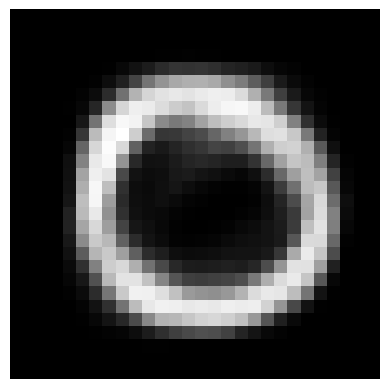

In [37]:
generate_digit(0, 1)

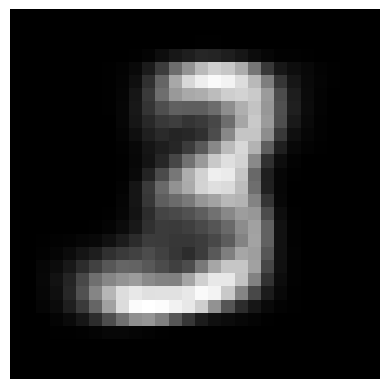

In [51]:
generate_digit(1, 0)

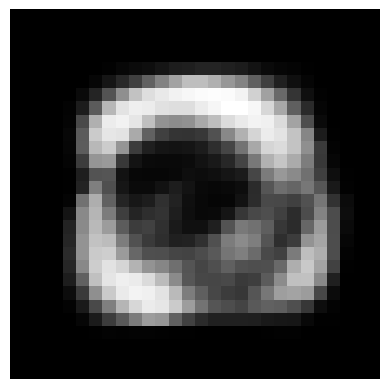

In [52]:
generate_digit(0.5, 1)

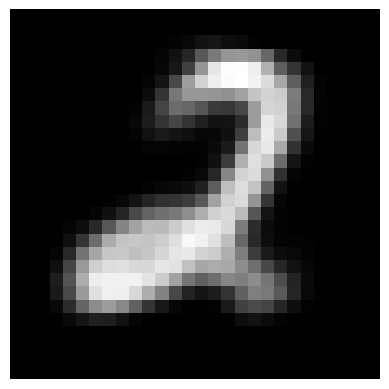

In [49]:
generate_digit(3, 0.5)

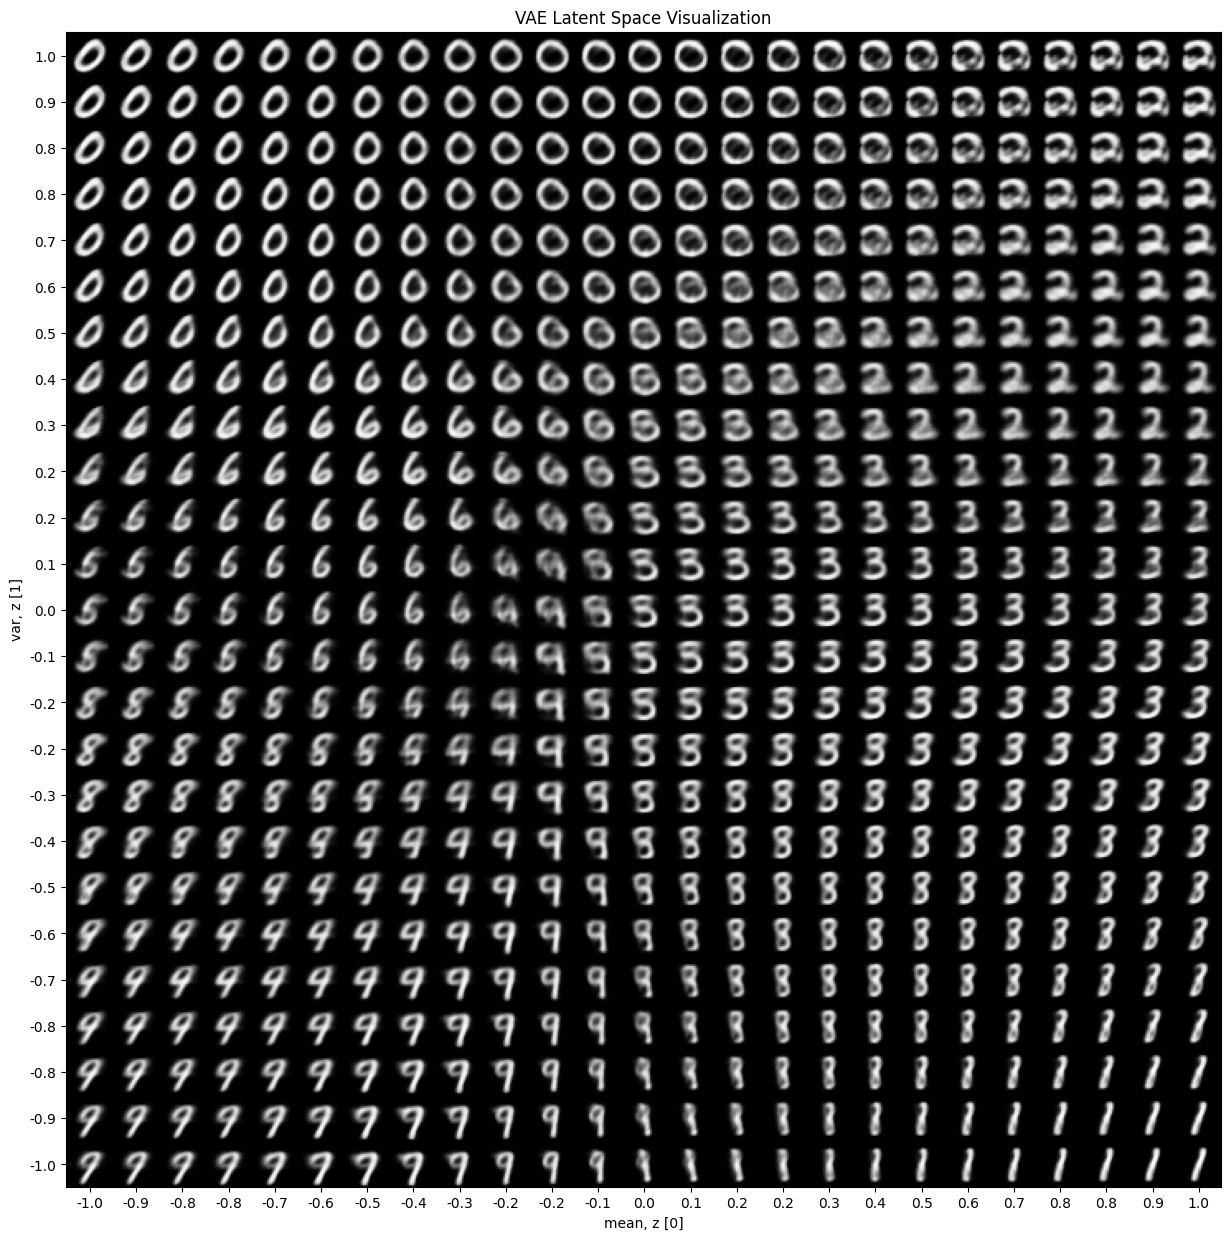

In [56]:
def plot_latent_space(model, scale=1.0, n=25, digit_size=28, figsize=15):
    # display a n*n 2D manifold of digits
    figure = np.zeros((digit_size * n, digit_size * n))

    # construct a grid 
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float)
            x_decoded = model.decode(z_sample)
            digit = x_decoded[0].detach().cpu().reshape(digit_size, digit_size)
            figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size,] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.title('VAE Latent Space Visualization')
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("mean, z [0]")
    plt.ylabel("var, z [1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(model)